In [1]:
import awkward as ak
import numpy as np
import hist as hs
from coffea import processor
from coffea.nanoevents.methods import vector, candidate
from numba import jit

from coffea.nanoevents import BaseSchema
import mplhep as hep
import matplotlib.pyplot as plt
from datetime import date
today = date.today()

plt.style.use(hep.style.CMS)

In [24]:
class LLP_ntuple_processor(processor.ProcessorABC):
    """
    This class is used to process the ntuples created by the LLP ntuple producer.
    """

    def delta_cls_gLLP(self, events):
        clusts = ak.zip(
            {
                'pt': ak.zeros_like(events.cscRechitClusterPhi),
                'phi': events.cscRechitClusterPhi,
                'eta': events.cscRechitClusterEta,
                'E': ak.zeros_like(events.cscRechitClusterPhi),
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          )
        gLLPs = ak.zip(
            {
                'pt': events.gLLP_pt,
                'phi': events.gLLP_phi,
                'eta': events.gLLP_eta,
                'E': events.gLLP_e,
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          )        
        cls_llp_pairs = ak.cartesian({
            "cls": clusts, 
            "llp": gLLPs
        }, nested = True) 
        
        deltaR = (cls_llp_pairs.cls).delta_r(cls_llp_pairs.llp)
        deltaEta = abs(cls_llp_pairs.cls.eta - cls_llp_pairs.llp.eta)
        deltaPhi = np.arctan2(np.sin(cls_llp_pairs.cls.phi - cls_llp_pairs.llp.phi), 
                              np.cos(cls_llp_pairs.cls.phi - cls_llp_pairs.llp.phi))
        
        return deltaR, deltaEta, deltaPhi
    
    def delta_cls_leadmuon(self, events):
        clusts = ak.zip(
            {
                'pt': ak.zeros_like(events.cscRechitClusterPhi),
                'phi': events.cscRechitClusterPhi,
                'eta': events.cscRechitClusterEta,
                'E': ak.zeros_like(events.cscRechitClusterPhi),
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          )
        leadMuons = ak.zip(
            {
                'pt': events.leadMuonPt,
                'phi': events.leadMuonPhi,
                'eta': events.leadMuonEta,
                'E': events.leadMuonE,
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          ) 
        cls_muon_pairs = ak.cartesian({
            "cls": clusts, 
            "muon": leadMuons
        }, nested = True)
 
        deltaR = (cls_muon_pairs.cls).delta_r(cls_muon_pairs.muon)
        deltaEta = abs(cls_muon_pairs.cls.eta - cls_muon_pairs.muon.eta)
        deltaPhi = np.arctan2(np.sin(cls_muon_pairs.cls.phi - cls_muon_pairs.muon.phi), 
                              np.cos(cls_muon_pairs.cls.phi - cls_muon_pairs.muon.phi))
        
        return deltaR, deltaEta, deltaPhi
        
    
    def process(self, events):
        # >>> some preprocessing >>>
        
        muoncut = abs(events.lepPdgId == 13)
        events['muonE'] = events.lepE[muoncut]
        events['muonPt'] = events.lepPt[muoncut]
        events['muonEta'] = events.lepEta[muoncut]
        events['muonPhi'] = events.lepPhi[muoncut]
        events['muonPdgId'] = events.lepPdgId[muoncut]
        events['muonDZ'] = events.lepDZ[muoncut]
        events['muonLooseId'] = events.lepLooseId[muoncut]
        events['muonTightId'] = events.lepTightId[muoncut]        
        
        muoncut = abs(events.muonEta) < 1.5
        events['muonE'] = events.muonE[muoncut]
        events['muonPt'] = events.muonPt[muoncut]
        events['muonEta'] = events.muonEta[muoncut]
        events['muonPhi'] = events.muonPhi[muoncut]
        events['muonPdgId'] = events.muonPdgId[muoncut]
        events['muonDZ'] = events.muonDZ[muoncut]
        events['muonLooseId'] = events.muonLooseId[muoncut]
        events['muonTightId'] = events.muonTightId[muoncut]
        
        events = events[(ak.count(events.muonPhi, axis=1) > 0)]
        leadcut = (ak.max(events.muonPt, axis=1, mask_identity=True) == events.muonPt)
        events['leadMuonE'] = ak.flatten(events.muonE[leadcut])
        events['leadMuonPt'] = ak.flatten(events.muonPt[leadcut])
        events['leadMuonEta'] = ak.flatten(events.muonEta[leadcut])
        events['leadMuonPhi'] = ak.flatten(events.muonPhi[leadcut])
        events['leadMuonPdgId'] = ak.flatten(events.muonPdgId[leadcut])
        events['leadMuonDZ'] = ak.flatten(events.muonDZ[leadcut])
        events['leadMuonLooseId'] = ak.flatten(events.muonLooseId[leadcut])
        events['leadMuonTightId'] = ak.flatten(events.muonTightId[leadcut])
        
        cls_llp_deltaR, cls_llp_deltaEta, cls_llp_deltaPhi = self.delta_cls_gLLP(events)
        cls_leadmuon_deltaR, cls_leadmuon_deltaEta, cls_leadmuon_deltaPhi = self.delta_cls_leadmuon(events)
        
        events['cscRechitCluster_llp_deltaR'] = cls_llp_deltaR
        events['cscRechitCluster_llp_deltaEta'] = cls_llp_deltaEta
        events['cscRechitCluster_llp_deltaPhi'] = cls_llp_deltaPhi
        
        events['cscRechitCluster_leadmuon_deltaR'] = cls_leadmuon_deltaR
        events['cscRechitCluster_leadmuon_deltaEta'] = cls_leadmuon_deltaEta
        events['cscRechitCluster_leadmuon_deltaPhi'] = cls_leadmuon_deltaPhi

        
        #print(events.cscRechitCluster_llp_deltaR)
        # <<< some preprocessing <<<
        
        dataset = events.metadata['dataset']
        out = {
            dataset: {},
            'cuts': {},
            'vars': {},
        }
        
        cscCuts = {'no_cut': ak.values_astype(ak.ones_like(events.cscRechitClusterJetVetoPt), 'bool')} #dummy truth vector of same shape as csc variables
        
        '''
        if events.metadata['dataset'] == 'signal':
            llp_acc_cut = (events.gLLP_csc == 1) 
        if events.metadata['dataset'] == 'background':
            llp_acc_cut = ak.values_astype(ak.ones_like(events.metEENoise), 'bool') #just a dummy 1D truth vector
            
        cscCuts['llp_acc_cut'] = llp_acc_cut
        '''
        
        cscCuts['llp_acc_cut'] = (events.gLLP_csc == 1) 
        cscCuts['csc_eff_cut'] = (events.nCscRechitClusters >= 1)
        
        cscCuts['cls_llp_deltaR_match_cut'] = ak.flatten((ak.min(events.cscRechitCluster_llp_deltaR, axis=2) == events.cscRechitCluster_llp_deltaR), axis=2)
        cscCuts['cls_llp_deltaR_cut'] = ak.flatten((events.cscRechitCluster_llp_deltaR < .4), axis=2)
        
        #cscCuts['met_cut'] = events.metEENoise >= 30 #event level
        #cscCuts['muon_veto'] = (events.cscRechitClusterMuonVetoPt < 20) 
        #cscCuts['jet_cut'] = (events.cscRechitClusterJetVetoPt < 10) 
        
        cscCuts['time_cut'] = ((events.cscRechitClusterTimeWeighted <= 12.5)&
                            (events.cscRechitClusterTimeWeighted >= -5  )) 
        
        cscCuts['ME11_veto'] = ((events.cscRechitClusterNRechitChamberPlus11 <= 0)&
                             (events.cscRechitClusterNRechitChamberMinus11 <= 0)) 
        
        cscCuts['ME12_veto'] = ((events.cscRechitClusterNRechitChamberPlus12 <= 0)&
                             (events.cscRechitClusterNRechitChamberMinus12 <= 0)) 
        
        cscCuts['re12_cut'] = (events.cscRechitCluster_match_RE12_0p4 == 0)
        cscCuts['mb1_cut'] = (events.cscRechitCluster_match_MB1Seg_0p4 == 0)
        cscCuts['rb1_cut'] = (events.cscRechitCluster_match_RB1_0p4 == 0)
        
        '''
        if events.metadata['dataset'] == 'signal':
            llp_eta_cut = abs(events.gLLP_eta) < 2
        if events.metadata['dataset'] == 'background':
            llp_eta_cut = llp_acc_cut
            
        cscCuts['llp_eta_cut'] = llp_eta_cut
        '''
        
        #cscCuts['llp_eta_cut'] = (abs(events.gLLP_eta) < 2)
        
        #cscCuts['time_spread_cut'] = (events.cscRechitClusterTimeSpreadWeightedAll <= 20)
        #cscCuts['cls_eta_cut'] = (abs(events.cscRechitClusterEta) < 1.9)
        #cscCuts['cls_size_cut'] = (events.cscRechitClusterSize > 100)
    
        '''
        cscCuts['cut_based'] = (((events.cscRechitClusterNStation10 > 1) & (abs(events.cscRechitClusterEta) < 1.9))|
                             ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 4) & (abs(events.cscRechitClusterEta) < 1.8))|
                             ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 3) & (abs(events.cscRechitClusterEta) < 1.6))|
                             ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 2) & (abs(events.cscRechitClusterEta) < 1.6))|
                             ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 1) & (abs(events.cscRechitClusterEta) < 1.1))
                            )
        '''
        #cscCuts['dphi_cut'] = (abs(events.cscRechitClusterMetEENoise_dPhi) < 0.75)
        #cscCuts['nrechits_cut'] = (events.cscRechitClusterSize > 130)
        
        
        __ = lambda x: x
        bins = 30
        cscVars = {
            #'cscRechitClusterMetEENoise_dPhi':       [bins,    0,   5, __, ],
            #'cscRechitClusterTimeSpreadWeightedAll': [bins,    0,  20, __, ],
            #'cscRechitClusterTimeWeighted':          [bins, -5.5,  13, __, ],
            #'cscRechitClusterSize':                  [bins,    0, 130, __, ],
            #'cscRechitClusterEta':                   [bins,    0,   4, abs,],
            #'cscRechitClusterNStation10':            [bins,  -10,  10, __, ],
            #'cscRechitClusterAvgStation10':          [bins,  -10,  10, __, ],
            'cscRechitCluster_llp_deltaR':           [bins,    0,   4, __, ],
            'cscRechitCluster_leadmuon_deltaR':      [bins,    0,   4, __, ],
            'cscRechitCluster_llp_deltaEta':         [bins,    0,   2, __, ],
            'cscRechitCluster_leadmuon_deltaEta':    [bins,    0,   4, __, ],
            'cscRechitCluster_llp_deltaPhi':         [bins,    0,   4, __, ],
            'cscRechitCluster_leadmuon_deltaPhi':    [bins,    0,   4, __, ],
        }

        for var in cscVars:
            bigCut = cscCuts['no_cut']
            v = cscVars[var]
            out['vars'][var] = 1 #quick and dirty way of doing this
            
            for cut in cscCuts:
                #print(cut)
                out['cuts'][cut] = 1
                
                bigCut = bigCut & cscCuts[cut]
                
                data = ak.flatten(events[var][bigCut], axis=None)
                data = v[3](data)

                
                out[dataset][f'{var} with {cut}'] = hs.Hist.new.Reg(v[0], v[1], v[2], name=var, label=var).Double()
                out[dataset][f'{var} with {cut}'].fill(data)           
    
        
        return out
         
    
    def postprocess(self, accumulator):
        return accumulator

In [25]:
date = today.strftime("%m_%d_%y")

fileset = {}
fileset['signal']     = ['root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v2/v3/normalized/BToKPhi_MuonGenFilter_mPhi1p0_ctau1000_1pb_weighted.root',]
#fileset['background'] = ['root://cmsxrootd.fnal.gov//store/user/christiw/displacedJetMuonAnalyzer/csc/V1p171/Data2018_UL/v3/normalized/ParkingBPH4_Run2018A_goodLumi.root']
out = processor.run_uproot_job(
    fileset,
    treename="MuonSystem",
    processor_instance=LLP_ntuple_processor(),
    executor=processor.futures_executor,
    executor_args={"schema": BaseSchema, "workers": 16},
    #maxchunks = 1
)

cuts = list(out['cuts'].keys())
varnames = list(out['vars'].keys())

Output()

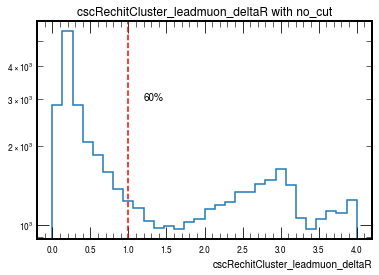

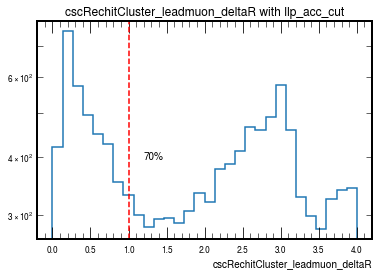

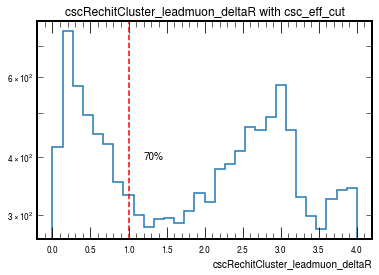

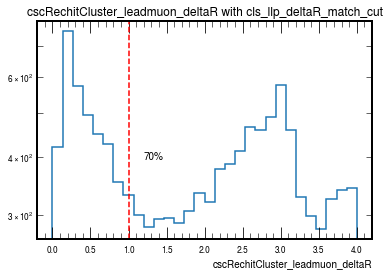

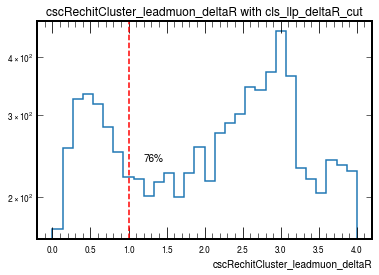

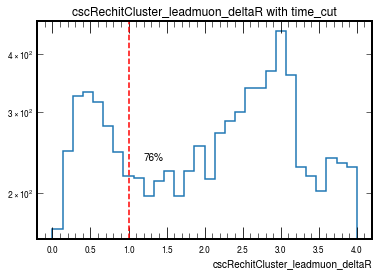

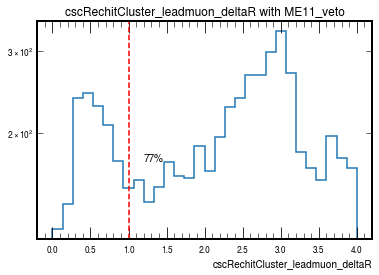

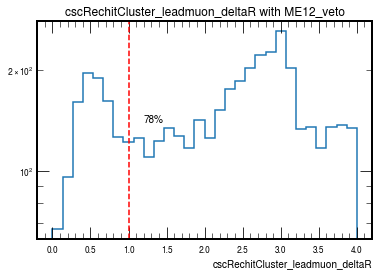

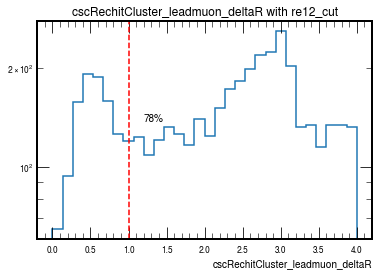

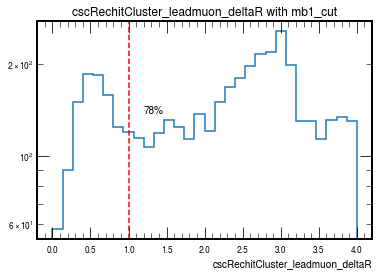

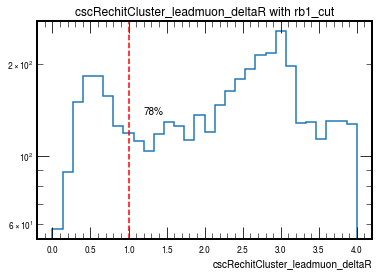

In [11]:
for hist in out['signal']:
    if 'cscRechitCluster_leadmuon_deltaR' in hist:    
        fig, ax = plt.subplots()
        signal = out['signal'][hist]
        hep.histplot(signal, ax=ax)
        ax.set_title(f'{hist}')
        ax.set_yscale('log')

        a = 1
        ax.axvline(a, color = "red", linestyle = '--')    

        ratio = signal[a*1j:].sum()/signal.sum()
        ax.text(a+.2,ax.get_ylim()[1]/2,"{:.0%}".format(ratio), fontsize=10)

/tmp/ipykernel_30983/1211472362.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


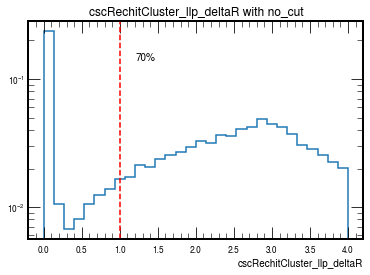

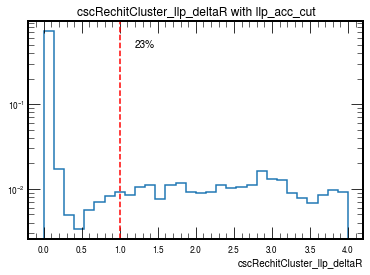

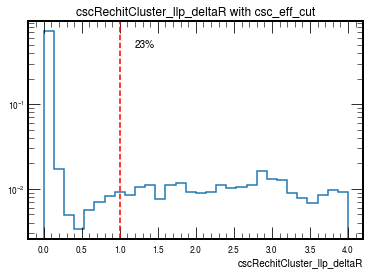

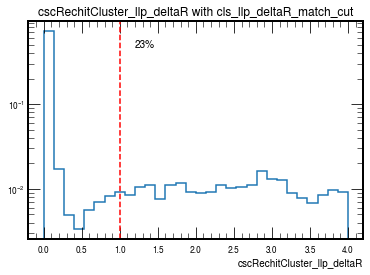

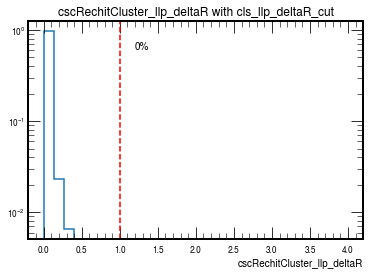

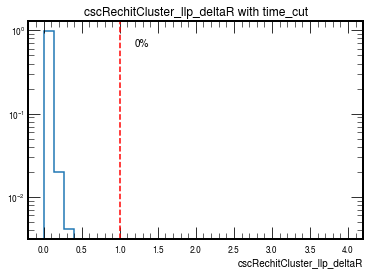

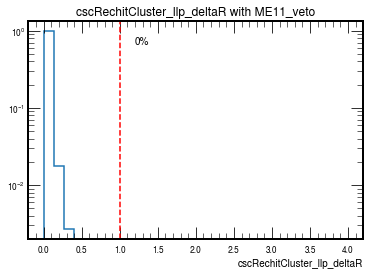

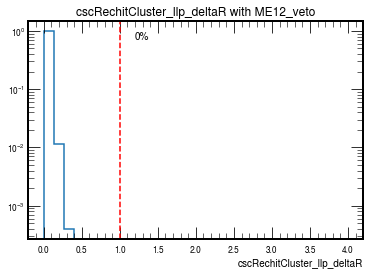

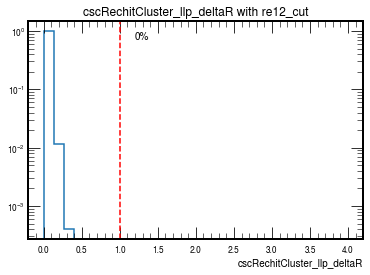

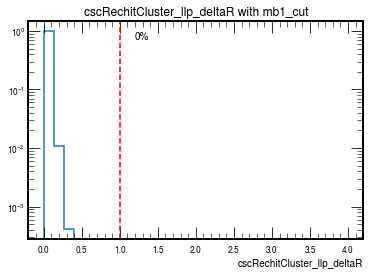

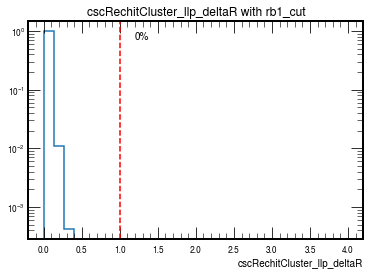

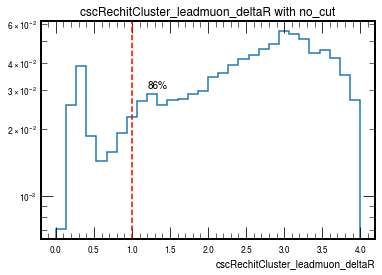

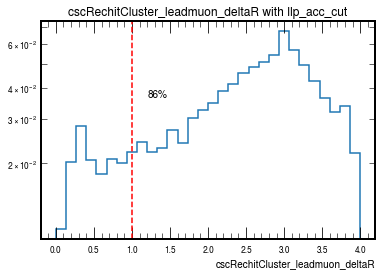

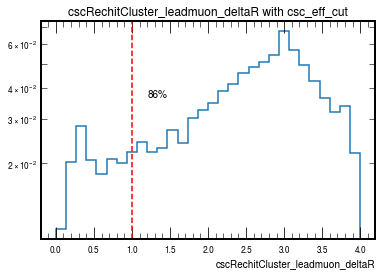

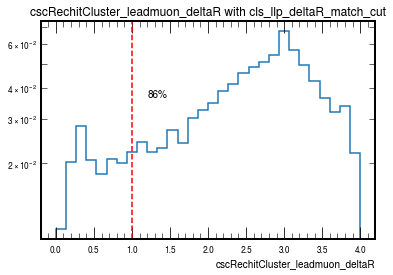

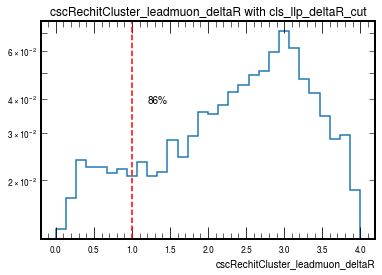

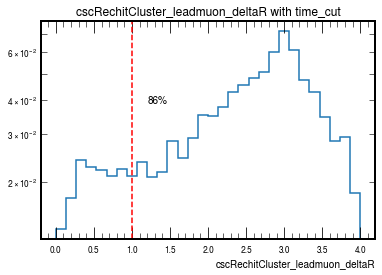

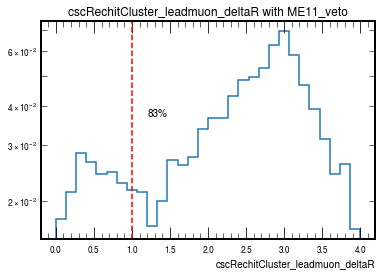

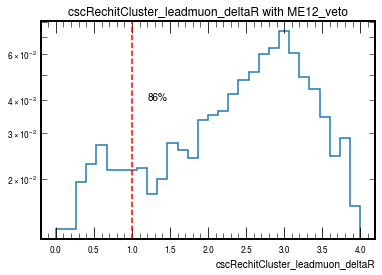

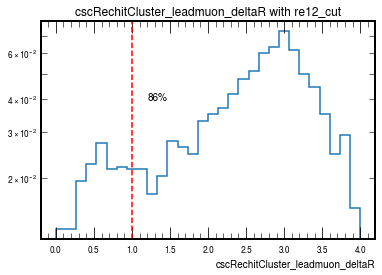

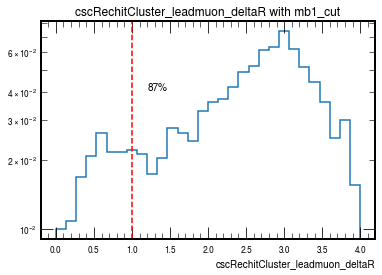

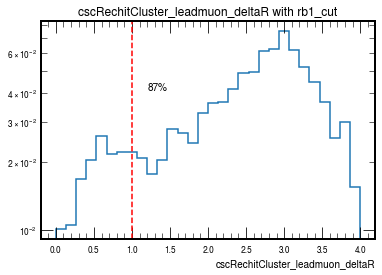

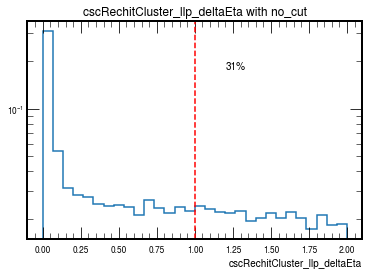

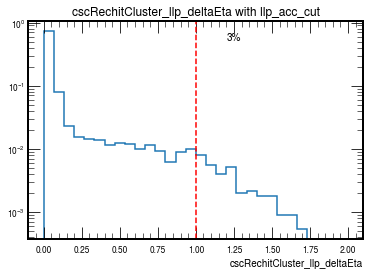

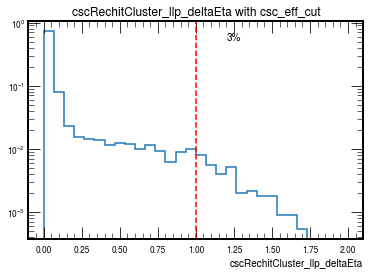

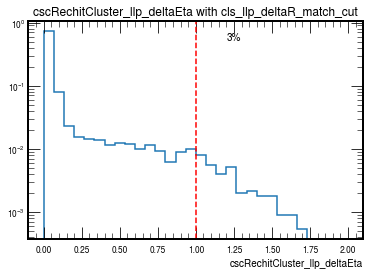

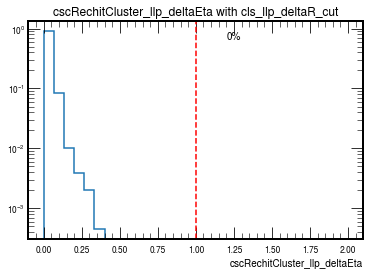

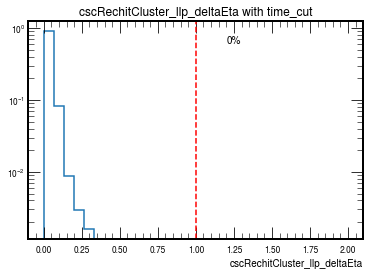

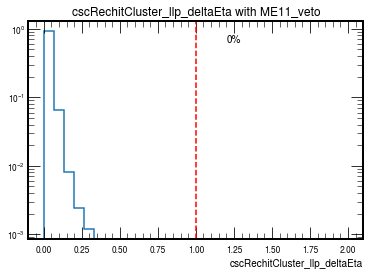

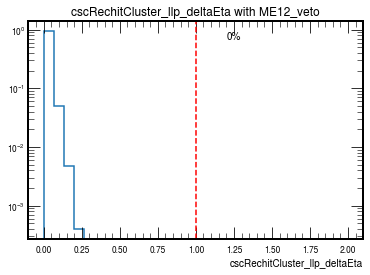

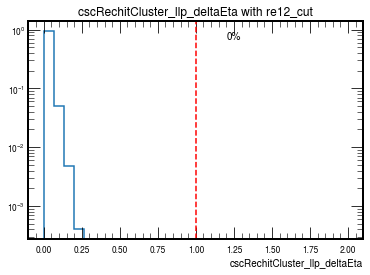

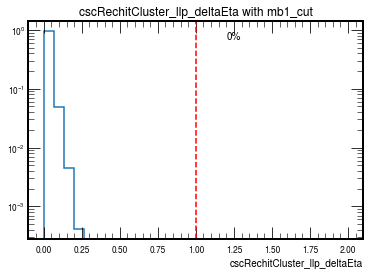

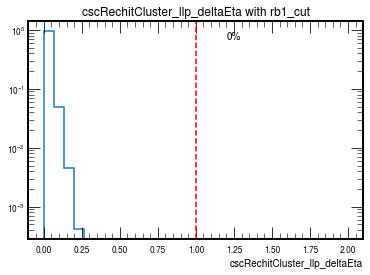

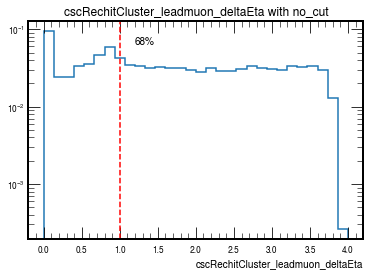

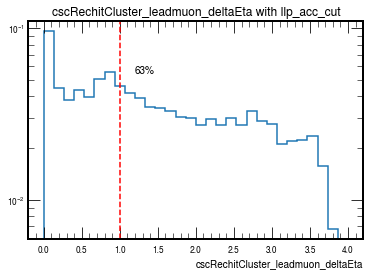

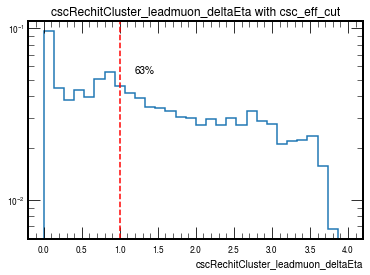

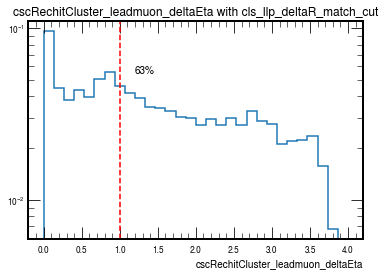

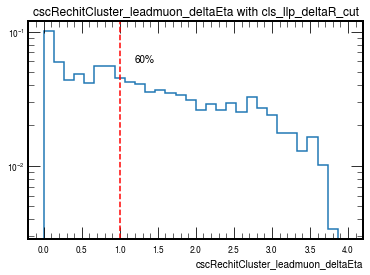

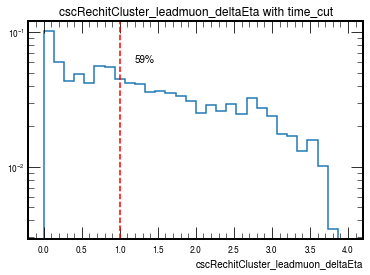

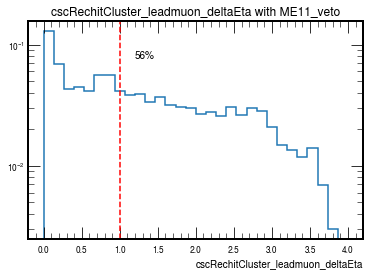

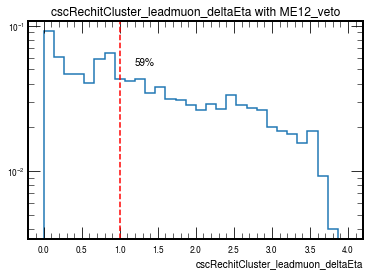

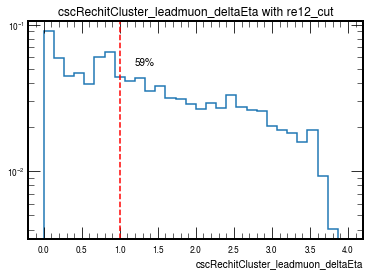

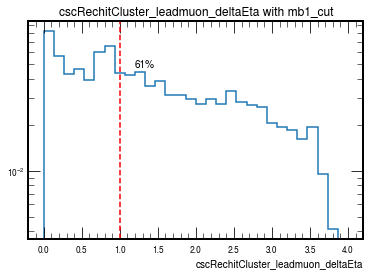

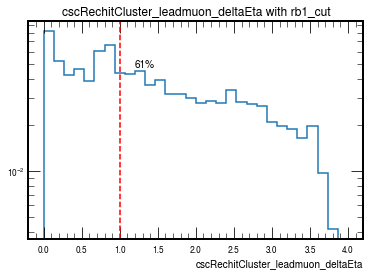

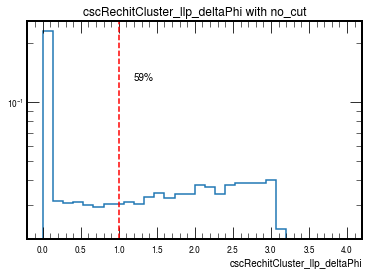

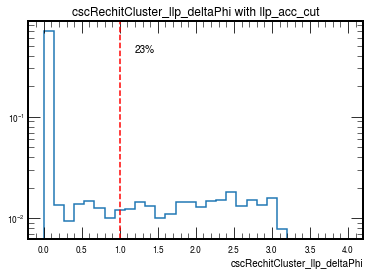

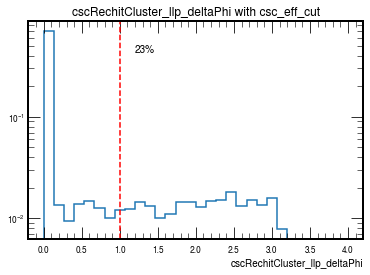

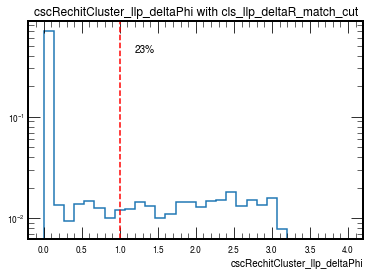

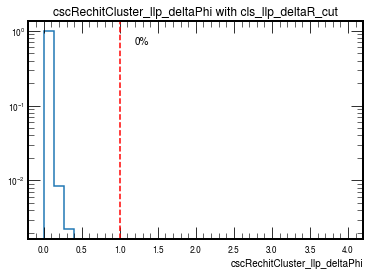

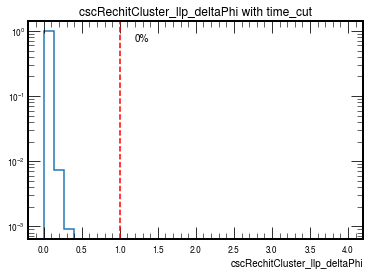

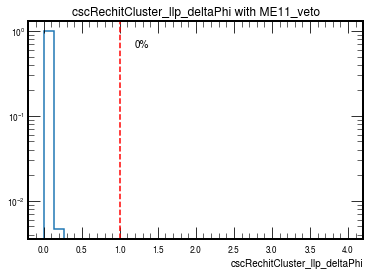

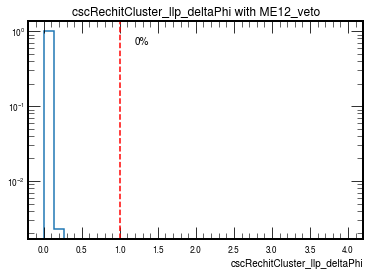

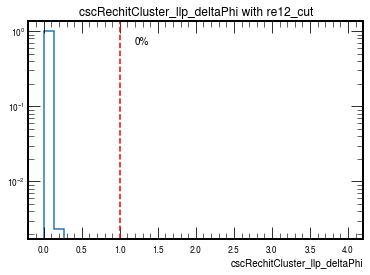

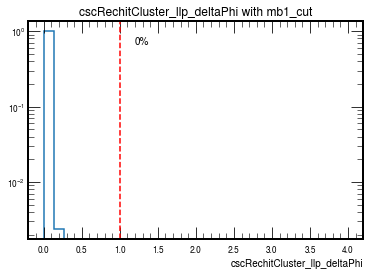

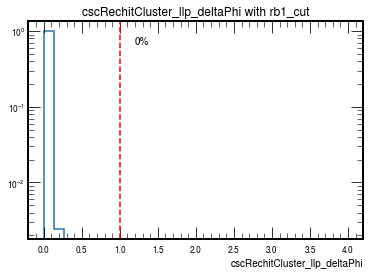

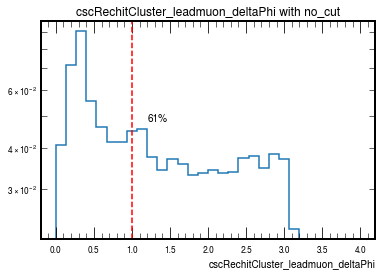

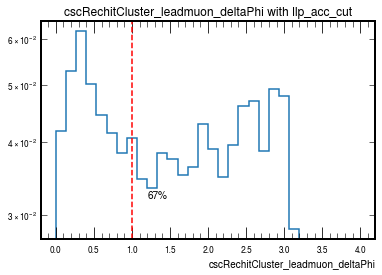

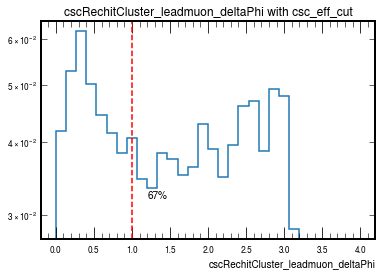

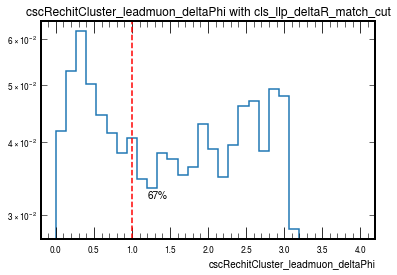

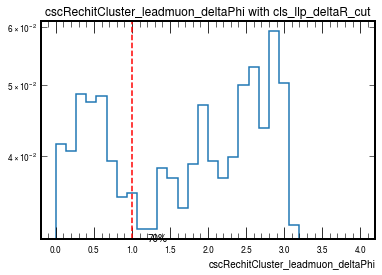

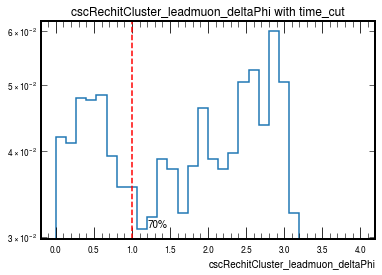

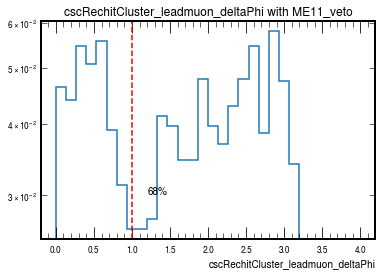

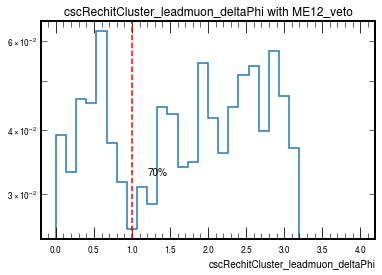

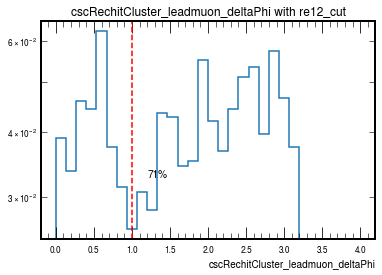

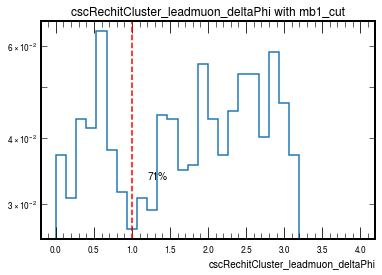

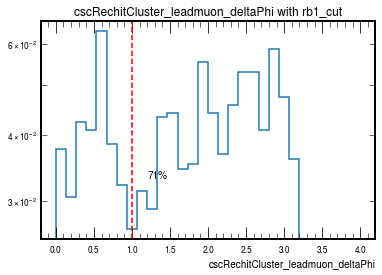

In [26]:
def savepdf(name):
    from matplotlib.backends.backend_pdf import PdfPages
    pdf = PdfPages(f'delta_plots_{date}/{name}.pdf')
    for hist in out['signal']:
        if name in hist:
            fig, ax = plt.subplots()
            signal = out['signal'][hist]
            hep.histplot(signal/signal.sum(), ax=ax)
            ax.set_title(f'{hist}')
            ax.set_yscale('log')

            a = 1
            ax.axvline(a, color = "red", linestyle = '--')    

            ratio = signal[a*1j:].sum()/signal.sum()
            ax.text(a+.2,ax.get_ylim()[1]/2,"{:.0%}".format(ratio), fontsize=10)
            pdf.savefig(fig)
    pdf.close()

for name in varnames:
    savepdf(name)

In [ ]:
from hist.intervals import ratio_uncertainty
def ratio(num, den, ax):
    ax.errorbar(
        x=num.axes[0].centers,
        y=num.view() / den.view() ,
        yerr=ratio_uncertainty(num.view(), den.view()),
        color="k",
        linestyle="none",
        marker="o",
        elinewidth=1,
    )
    return ax

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import warnings

with warnings.catch_warnings(): #i don't need to see all the divide by zero warnings
    warnings.simplefilter("ignore")

    for varname in varnames:
        pdf = PdfPages(f'varPlots_sb_clsCuts_{date}/{varname}_cutflow_sb.pdf')

        for cut in cuts:
            fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(np.sqrt(2)*5,5))

            signal = out['signal'][f'var: {varname} with cut: {cut}']
            background = out['background'][f'var: {varname} with cut: {cut}']

            hep.histplot(signal/signal.sum(), label='signal', ax=ax[0])
            hep.histplot(background/background.sum(), label='background', ax=ax[0])
            ax[0].set_title(f'{varname} with {cut} cut')
            ax[0].legend()
            ax[0].tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
            ax[0].set(xlabel=None)
            ax[0].set_yscale('log')

            ratio(signal/signal.sum(), background/background.sum(), ax[1])
            ax[1].set_xlim(ax[0].get_xlim())
            ax[1].set(xlabel=varname)
            ax[1].set_yscale('log')
            fig.subplots_adjust(wspace=0, hspace=.05)
            pdf.savefig(fig)
            print(f'var: {varname} with cut: {cut} saved in a pdf')
        pdf.close()
